In [100]:
import pandas as pd 
import numpy as np 
import os , sys  
import re 
import networkx as nx 
%store -r data_trad
from IPython.display import clear_output
%store -r Dict  
import matplotlib.pyplot as plt
import spacy 
data=data_trad
discri = Dict.keys()

In [63]:
def stop_it_en(text): 

    try :

        my_doc = nlp(text) 
    except: ValueError 

    # Create list of word tokens
    token_list = []
    for token in my_doc:
        token_list.append(token)


    filtered_sentence =[] 

    for word in token_list:
        lexeme = nlp.vocab[word.text]
        if lexeme.is_stop == False: 
            if lexeme.is_punct == False:
                filtered_sentence.append(word.text) 
    return filtered_sentence  


def Tokenize_by_loc_en(index):  

    return stop_it_en(data.presentation_clean.iloc[index]) 




def Clean_presentation(data):  
    
    global nlp 
    try :
        nlp=spacy.load('en')     
        print('download of "en" dataset') 
    except : ValueError
    l= []
    for i in range(len(data)):  
        print(f'étape {i}')
        l.append(Tokenize_by_loc_en(i))
    return l 



In [15]:
Mrpropre(['azer','aear','%'])

['azer', 'aear']

In [91]:
def Mrpropre(x): 
    l=list(x).copy() 
    for i in range(len(l)):  
        try :  
            if len(l[i]) < 3: 
                del l[i]
            if l[i].isalpha()==False : 
                del l[i]   
        except: 
            pass 
    return l 

In [47]:
for i in range(len(data_trad)): 
    if data_trad['presentation_en'].iloc[i] == '': 
        data_trad['presentation_en'].iloc[i] =data_trad['presentation'].iloc[i]

In [58]:
data_trad['presentation_clean']=data_trad['presentation_en'].apply(lambda x : re.sub(r'[^a-zA-Z]',
                                                                                     " ", 
                                                                                     x))


In [68]:
data_trad['presentation_clean'] = Clean_presentation(data)

download of "en" dataset
étape 0
étape 1
étape 2
étape 3
étape 4
étape 5
étape 6
étape 7
étape 8
étape 9
étape 10
étape 11
étape 12
étape 13
étape 14
étape 15
étape 16
étape 17
étape 18
étape 19
étape 20
étape 21
étape 22
étape 23
étape 24
étape 25
étape 26
étape 27
étape 28
étape 29
étape 30
étape 31
étape 32
étape 33
étape 34
étape 35
étape 36
étape 37
étape 38
étape 39
étape 40
étape 41
étape 42
étape 43
étape 44
étape 45
étape 46
étape 47
étape 48
étape 49
étape 50
étape 51
étape 52
étape 53
étape 54
étape 55
étape 56
étape 57
étape 58
étape 59
étape 60
étape 61
étape 62
étape 63
étape 64
étape 65
étape 66
étape 67
étape 68
étape 69
étape 70
étape 71
étape 72
étape 73
étape 74
étape 75
étape 76
étape 77
étape 78
étape 79
étape 80
étape 81
étape 82
étape 83
étape 84
étape 85
étape 86
étape 87
étape 88
étape 89
étape 90
étape 91
étape 92
étape 93
étape 94
étape 95
étape 96
étape 97
étape 98
étape 99
étape 100
étape 101
étape 102
étape 103
étape 104
étape 105
étape 106
étape 107
étape

In [85]:
def fatigue(x): 
    if type(x)==str: 
        x=re.sub(r'[^a-zA-Z]', " ", x) 
        return x.split(' ') 
    else: 
        return x

In [86]:
data_trad['presentation_clean']=data_trad['clean_presentation_trad'].apply(fatigue)

In [95]:
def fuck(x): 
    seq=[] 
    for el in x: 
        if el == '': 
            continue 
        seq.append(el)
    return seq
data_trad['clean_presentation_trad']=data_trad['presentation_clean'].apply(Mrpropre).apply(fuck)

In [107]:
data_trad.to_csv('main_data.csv')

In [111]:
## SYNONYMS METHOD HERE §  



%store -r Dict 
discri = Dict.keys()

In [112]:
data_trad=data_trad.set_index('id')
trad =data_trad['clean_presentation_trad']
ID_list = data_trad.index  

In [116]:
def check_it(Dict,trad,ID_list,discri): 
    connection={}
    i = 0 
    for idx in ID_list:  
        
        checking=[Dict[el.lower()] for el in trad[idx] if el in discri] 
        i+=1 
        if i % 10 == 0 : 
            print(f'étape {i} sur {len(ID_list)}') 
            clear_output(wait=True)
        for idx2 in ID_list : 
            if idx2==idx  : 
                continue              
            connection[(idx,idx2)] = 0
            to_check=set.union( * [Dict[el.lower()] for el in trad[idx2]]) 
            for val in checking :  
                connection[(idx,idx2)] += any(el in to_check for el in val)*1  
            if  (idx2,idx)  in connection.keys() : 
                connection[(idx,idx2)]=min(connection[(idx,idx2)], 
                                          connection[(idx2,idx)]) 
                
                del connection[(idx2,idx)]
            
    for key in list(connection.keys()) : 
        if connection[key] > 100 :
            connection[key]=100 
        if connection[key] >3:
            continue  
        del connection[key]
    return connection


In [127]:
def Create_network(trad,ID_list,discri,max_df,max_features=len(trad),minimize=True): 
    
    from sklearn.feature_extraction.text import TfidfVectorizer 

    vectorizer= TfidfVectorizer(max_df=max_df,max_features=max_features)
    X = vectorizer.fit_transform(trad.apply(lambda x: ' '.join(x)))
    print('feature name done ')
    discri=vectorizer.get_feature_names() 
    
    tojson=check_it(Dict,trad,ID_list,discri) 
    print('tojson done')
    A, B =list(zip(*tojson.keys())) 
    weights = tojson.values() 
    
    Network=pd.DataFrame()
    Network['A']=A
    Network['B']=B 
    Network['WEIGHTS']=weights  
    if minimize ==True :
        def minimize(x): 
            if x > 10 : 
                x =10 
            return x 
        Network['WEIGHTS']=Network['WEIGHTS'].apply(minimize)
    print('dataframe created') 
    print(f'lenght of feature in graph construction :{len(discri)}')
    Network.A=Network.A.apply(lambda x : data_trad[['nom']].loc[x].values[0])
    Network.B=Network.B.apply(lambda x : data_trad[['nom']].loc[x].values[0]) 
    G=nx.from_pandas_edgelist(Network , 'A', 'B')
    return G , X , vectorizer

In [132]:
G, X, vectorizer=Create_network(trad,ID_list,discri,max_df=0.03,max_features=len(trad))

tojson done
dataframe created
lenght of feature in graph construction :209


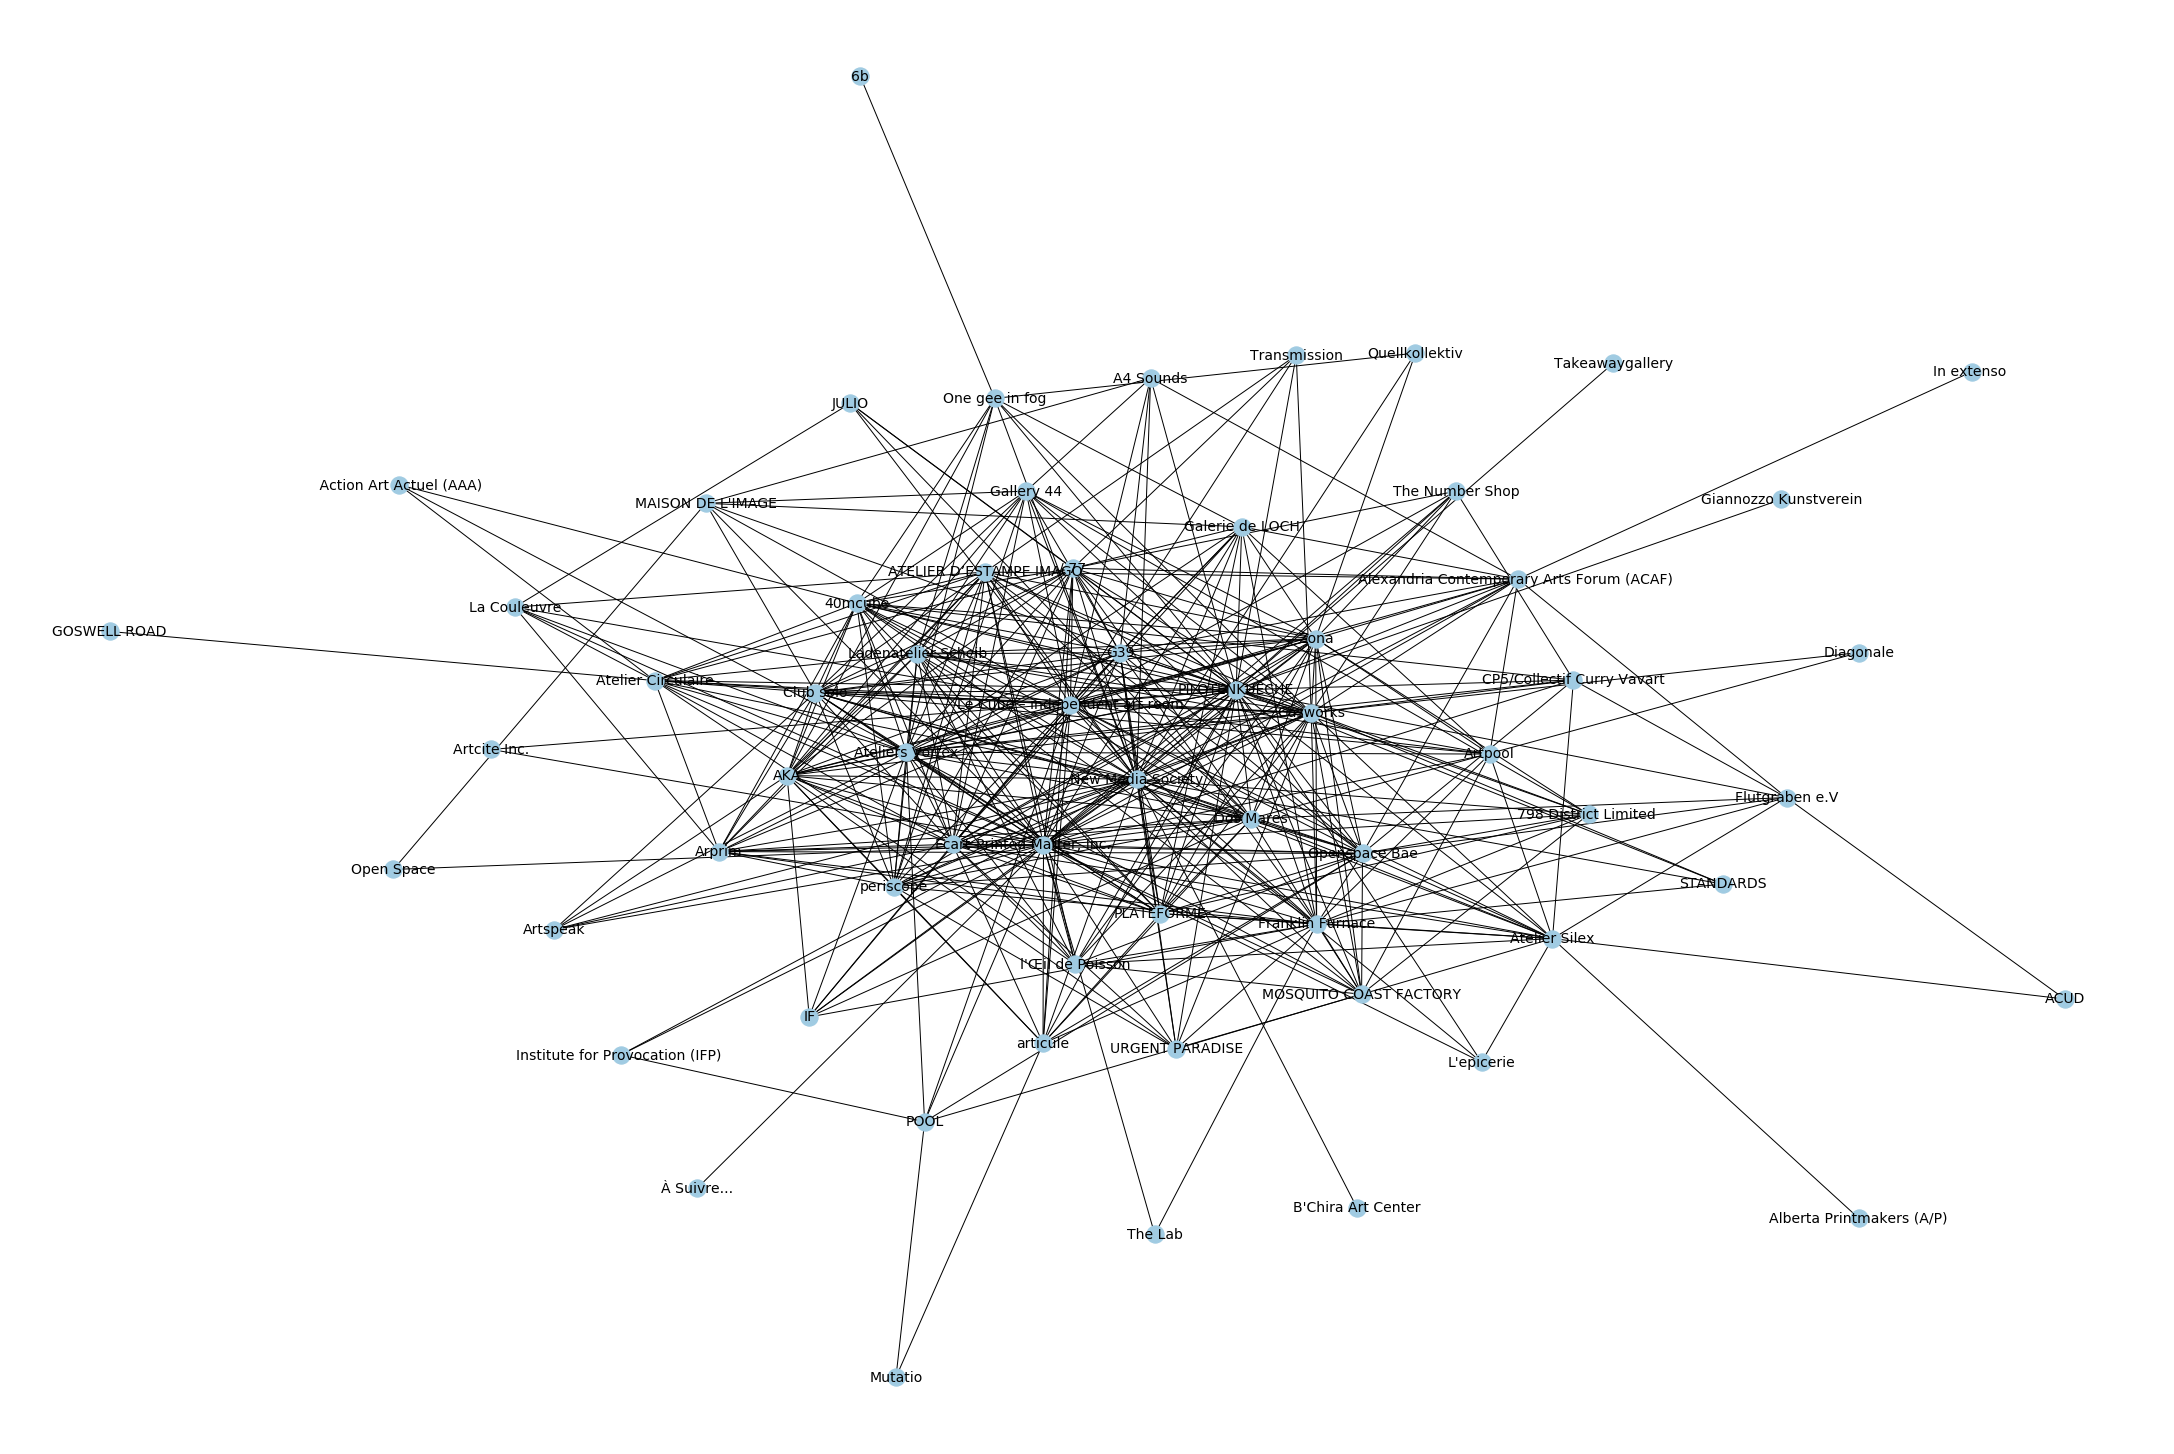

In [133]:
plt.rcParams['figure.figsize']=(30,20)
nx.draw_kamada_kawai(G ,
        node_color='#A0CBE2',
        width=1, edge_cmap=plt.cm.Blues,
        font_size=14, with_labels=True) 

In [120]:

arg= np.argmax(X.toarray(),axis=0)
keyw=np.array(vectorizer.get_feature_names())

In [121]:
key_by_id=keyw[arg]

In [122]:
key_by_id.shape
data_trad['ultimakey']=key_by_id

In [123]:
from networkx.readwrite import json_graph
import json

In [138]:
data2 = json_graph.node_link_data(G)
with open('data_freq0-03.json', 'w') as f:
    json.dump(data2, f)

In [125]:
%store data_trad

Stored 'data_trad' (DataFrame)


In [136]:
data_trad.to_csv('datav4.csv')

In [140]:
import joblib as job 
job.dump(Dict,'dict_clean.job')

['dict_clean.job']